<h1 align="center" style="background-color:#616161;color:white">Next play prediction using Logistic Regression</h1>

<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [24]:
# Root path
#root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
root = "/home/badrul/git/EventPrediction" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Import Libraries</div>

<code>Standard code used in every page. Not all of these libraries are used here.</code>

In [25]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used Tracer()() for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time
#from datetime import timedelta # Deprecated

# Visualization
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [26]:
fieldList="t, UserID, HrsFrom5pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs,t23_5hrs, t24hrs, t24_5hrs, t1wk,t2wks,t3wks,t4wks"
#fieldList="t, UserID, HrsFrom5pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t10,t12hrs,t23_5hrs, t24hrs, t24_5hrs, t1wk,t2wks,t3wks,t4wks"
def getTrainAndTestData():
    con = sqlite3.connect(dbPath)
    c = con.cursor()

    # Get list of UserIDs 
    users = pd.read_sql_query("Select UserID from tblUsers Where tblUsers.TestUser = 0",con)

    trainDf=pd.DataFrame(columns=[x.strip() for x in fieldList.split(',')])  # Create an emmpty df
    testDf=pd.DataFrame(columns=[x.strip() for x in fieldList.split(',')])  # Create an emmpty df
    periodsInAMonth=int(60/periodGranularity)*24*7*4

    totalRows=0
    
    for user in users.itertuples():
        # Get training dataset
        SqlStr="SELECT {} from tblTimeSeriesData where UserID = {}".format(fieldList,user.userID)
        df = pd.read_sql_query(SqlStr, con)
        if len(df)>int(periodsInAMonth*3):  # user must have at least 3 months worth of data
            totalRows += len(df)

            # Cut-off 1
            k = random.randint(periodsInAMonth, len(df))
            #Tracer()()  -- for debugging purposes
            testDf = testDf.append(df.iloc[k:k+periodsInAMonth])[df.columns.tolist()]

            tmp = df.drop(df.index[k:k+periodsInAMonth])

            # Cut-off 2
            k = random.randint(periodsInAMonth, len(tmp))
            testDf = testDf.append(tmp.iloc[k:k+periodsInAMonth])[df.columns.tolist()]
            trainDf = trainDf.append(tmp.drop(tmp.index[k:k+periodsInAMonth]))[df.columns.tolist()]

    if len(trainDf)+len(testDf) == totalRows:
        print('Ok')
    else:
        print("Incorrect. Total Rows = {}. TestDf+TrainDf rows = {}+{}={}".format(totalRows,len(testDf),len(trainDf),len(testDf)+len(trainDf)))
        
    return trainDf, testDf

def getHiddenTestUsers(firstNPerc=1.0):
    con = sqlite3.connect(dbPath)
    c = con.cursor()

    # Get list of UserIDs 
    users = pd.read_sql_query("Select UserID from tblUsers Where tblUsers.TestUser = 1",con)

    
    testDf=pd.DataFrame(columns=[x.strip() for x in fieldList.split(',')])  # Create an emmpty df
    periodsInAMonth=int(60/periodGranularity)*24*7*4

    totalRows=0
    
    for user in users.itertuples():
        # Get training dataset
        SqlStr="SELECT {} from tblTimeSeriesData where UserID = {}".format(fieldList + ',PeriodID',user.userID)
    
        df = pd.read_sql_query(SqlStr, con)
        df["PeriodID"] = df["PeriodID"].astype(int)
        df.sort_values(['PeriodID'])
        totalRows += len(df)
        # Caluclate period cutt-off
        cutoff = int(len(df)*firstNPerc)
        testDf = testDf.append(df.iloc[0:cutoff])[df.columns.tolist()]
 
    testDf["PeriodID"] =  testDf["PeriodID"].astype(int)
    testDf["UserID"] =  testDf["UserID"].astype(int)
    testDf.sort_values(['UserID','PeriodID'], inplace=True)
    return testDf


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [27]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath_sml']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']
periodGranularity = int(settingsDict['periodGranularity'])

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Other setup</div>


<code>None</code>

<h3 style="background-color:#616161;color:white">1. Get train & test data</h3>

In this section we go through every user, one at a time, and randomly select 2 sections of the dataset to use as test data. The code here could be improved to make it any n cut-off points. 

More importantly, we ensure that each test period covers an entire months worth of data in order to reduce pollution between training and test data. (So first pick cut-off points, then move forward by a month to get the range of the test data)

<br>

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Get train and test data</div>

In [28]:
trainDf,testDf = getTrainAndTestData()

Ok


<h3 style="background-color:#616161;color:white">2. Logistic Regression Model</h3>

In [29]:
X = trainDf.drop(['t','UserID'], 1).values
Y = trainDf['t'].values.astype(int) 

# fit a logistic regression model to the data
model = LogisticRegression(C=1)
model.fit(X, Y)
print(model)

# make predictions
X = testDf.drop(['t','UserID'], 1).values
Y = testDf['t'].values.astype(int)

predicted = model.predict(X)
# summarize the fit of the model
print(metrics.classification_report(Y,predicted))
print(metrics.confusion_matrix(Y,predicted))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.97      0.98      0.97    199703
          1       0.78      0.73      0.75     21288

avg / total       0.95      0.95      0.95    220991

[[195208   4495]
 [  5663  15625]]


In [30]:
coeffs = np.reshape(np.round(model.coef_,5),(-1,1))

coeffs=np.concatenate((np.reshape(fieldList.split(',')[2:],(-1,1)),coeffs),axis=1)
pd.DataFrame(coeffs,columns=['Field','Coeff'])

,Field,Coeff
0,HrsFrom5pm,-0.03363
1,isSun,-0.49574
2,isMon,-0.47227
3,isTue,-0.51
4,isWed,-0.50661
5,isThu,-0.50323
6,isFri,-0.51004
7,isSat,-0.5264
8,t1,4.05093
9,t2,0.17647


In [33]:
testDf2 = getHiddenTestUsers(firstNPerc=0.5)  # Get the first half of everyones history
# make predictions
X = testDf2.drop(['t','UserID','PeriodID'], 1).values
Y = testDf2['t'].values.astype(int)

predicted = model.predict(X)
# summarize the fit of the model
print(metrics.classification_report(Y,predicted))
print(metrics.confusion_matrix(Y,predicted))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97    192600
          1       0.79      0.75      0.77     24633

avg / total       0.95      0.95      0.95    217233

[[187602   4998]
 [  6270  18363]]


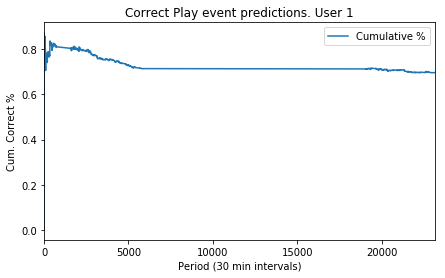

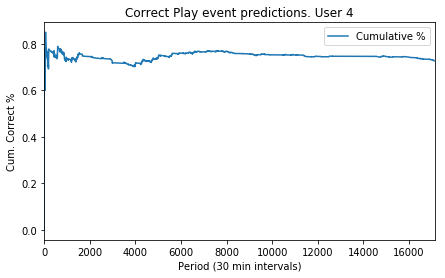

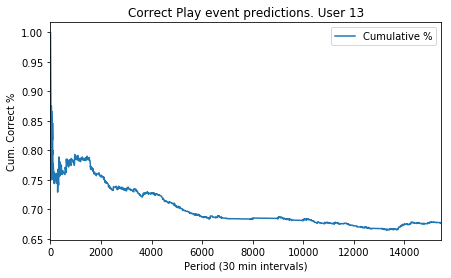

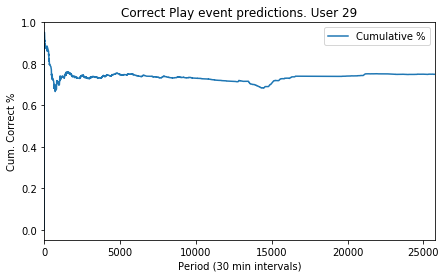

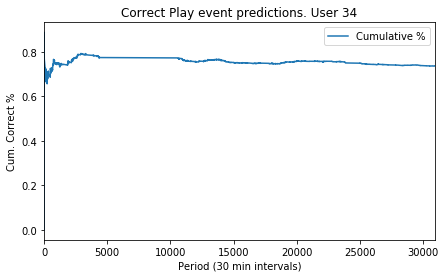

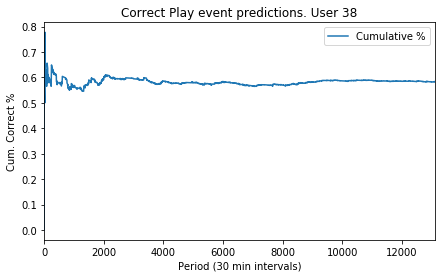

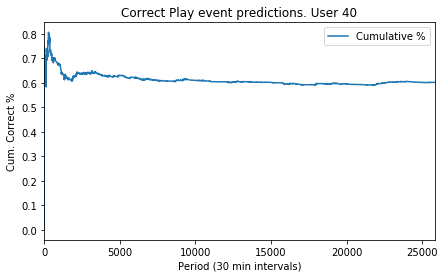

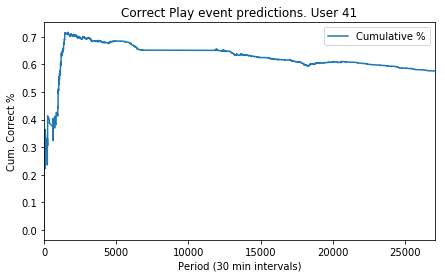

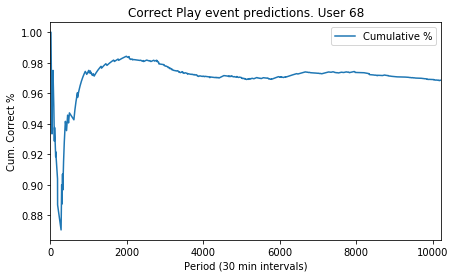

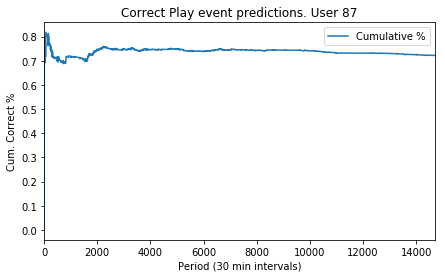

In [32]:
df=pd.DataFrame({'UserID': testDf2.UserID.values, 'Actual':Y.tolist(), 'Predicted':predicted.tolist()})
df['Period'] = df.index
df['Correct'] = (df['Actual'] == df['Predicted'])*1
df1 = df[df.Actual==1]
df1.set_index(['UserID','Period'],inplace=True)

df1= df1.assign(**{'Cum Correct': df1.groupby(level=0)["Correct"].cumsum()})
df1= df1.assign(**{'Cum Total': df1.groupby(level=0)["Actual"].cumsum()})
df1= df1.assign(**{'Cumulative %': df1.groupby(level=0)["Correct"].cumsum()/df1.groupby(level=0)["Actual"].cumsum()})

for u in df1.index.get_level_values(0).unique():
    tmp=df1.loc[u].head(5000)
    ax=tmp.plot(y='Cumulative %',title='Correct Play event predictions. User {}'.format(u),figsize=(7,4),x=(tmp.index.values - min(tmp.index.values)))
    ax.set_ylabel("Cum. Correct %")
    ax.set_xlabel("Period (30 min intervals)")